In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import SCORERS
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import StackingClassifier

from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegressionCV

from sklearn.dummy import DummyClassifier

from sklearn.calibration import calibration_curve

from sklearn.calibration import CalibratedClassifierCV

In [2]:
from hcdr import load_datasets, preprocessing_transformations, make_prep_pipeline, prevAppsFeaturesAggregater

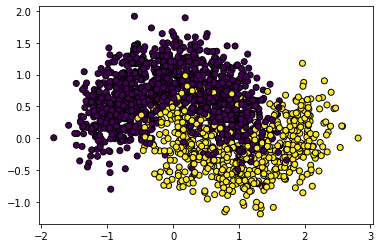

In [48]:
X,y = make_moons(n_samples=(1200, 600), noise=0.3)
plt.scatter(X[:,0], X[:,1], c=y, edgecolors="k")

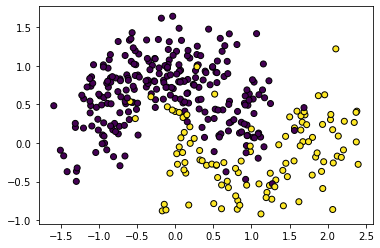

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolors="k")

In [5]:
lr = LogisticRegression(C=1, class_weight='balanced')
lr.fit(X_train, y_train)

y_train_pred_proba = lr.predict_proba(X_train)[:,1]
y_test_pred_proba = lr.predict_proba(X_test)[:,1]
score = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')
print(np.round((roc_auc_score(y_train, y_train_pred_proba), np.mean(score), roc_auc_score(y_test, y_test_pred_proba)), 5))
# plt.scatter(X_test[:,0], X_test[:,1], c=(y_test_pred_proba>0.5), edgecolors="k")

[0.92418 0.92383 0.93607]


In [49]:
knn = KNeighborsClassifier(n_neighbors=271, weights='distance', p=2)
knn.fit(X_train, y_train)

y_train_pred_proba = knn.predict_proba(X_train)[:,1]
y_test_pred_proba = knn.predict_proba(X_test)[:,1]
score = cross_val_score(knn, X_train, y_train, cv=5, scoring='roc_auc')
print(np.round((roc_auc_score(y_train, y_train_pred_proba), np.mean(score), roc_auc_score(y_test, y_test_pred_proba)), 5))
# plt.scatter(X_test[:,0], X_test[:,1], c=(y_test_pred_proba>0.5), edgecolors="k")

[1.      0.96237 0.97215]


(array([172.,  35.,  27.,   5.,  14.,   7.,   6.,  18.,  40.,  36.]),
 array([0.00206867, 0.0940004 , 0.18593213, 0.27786386, 0.3697956 ,
        0.46172733, 0.55365906, 0.64559079, 0.73752252, 0.82945426,
        0.92138599]),
 <BarContainer object of 10 artists>)

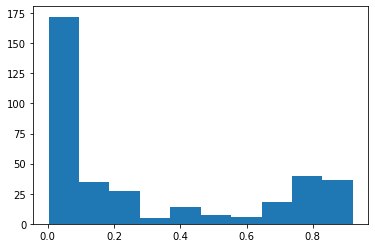

In [51]:
plt.hist(y_test_pred_proba)

In [7]:
rfc = RandomForestClassifier(max_depth=5, class_weight='balanced', random_state=0)
rfc.fit(X_train, y_train)

y_train_pred_proba = rfc.predict_proba(X_train)[:,1]
y_test_pred_proba = rfc.predict_proba(X_test)[:,1]
score = cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc')
print(np.round((roc_auc_score(y_train, y_train_pred_proba), np.mean(score), roc_auc_score(y_test, y_test_pred_proba)), 5))
# plt.scatter(X_test[:,0], X_test[:,1], c=(y_test_pred_proba>0.5), edgecolors="k")

[0.97623 0.95455 0.96827]


In [8]:
svc = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=0)
svc.fit(X_train, y_train)

y_train_pred_proba = svc.predict_proba(X_train)[:,1]
y_test_pred_proba = svc.predict_proba(X_test)[:,1]
score = cross_val_score(svc, X_train, y_train, cv=5, scoring='roc_auc')
print(np.round((roc_auc_score(y_train, y_train_pred_proba), np.mean(score), roc_auc_score(y_test, y_test_pred_proba)), 5))

[0.92416 0.92373 0.93604]


In [9]:
dummy = DummyClassifier(strategy='stratified', random_state=99)
dummy.fit(X_train, y_train)

y_train_pred_proba = dummy.predict_proba(X_train)[:,1]
y_test_pred_proba = dummy.predict_proba(X_test)[:,1]
score = cross_val_score(dummy, X_train, y_train, cv=5, scoring='roc_auc')
print(np.round((roc_auc_score(y_train, y_train_pred_proba), np.mean(score), roc_auc_score(y_test, y_test_pred_proba)), 5))

[0.47979 0.49683 0.56782]


In [37]:
vote_clf = VotingClassifier(estimators=[
    ('lr', lr),
    ('knn', knn),
    ('rfc', rfc),
    ('svc', svc),
    ('dummy', dummy)
], voting='soft')

_ = vote_clf.fit(X_train, y_train)


y_train_pred_proba = vote_clf.predict_proba(X_train)[:,1]
y_test_pred_proba = vote_clf.predict_proba(X_test)[:,1]
score = cross_val_score(vote_clf, X_train, y_train, cv=5, scoring='roc_auc')
print(np.round((roc_auc_score(y_train, y_train_pred_proba), np.mean(score), roc_auc_score(y_test, y_test_pred_proba)), 5))
# plt.scatter(X_test[:,0], X_test[:,1], c=(y_test_pred_proba>0.5), edgecolors="k")

[0.97947 0.92901 0.95418]


In [11]:
y_test_pred = y_test_pred_proba>0.5
mask = y_test != y_test_pred
np.sum(mask)

34

In [12]:
df = pd.DataFrame(vote_clf.transform(X_test)[mask][:, [1,3,5, 7]], columns=['lr_1', 'knn_1', 'rfc_1', 'svm_1']) #['lr_0', 'lr_1', 'knn_0', 'knn_1', 'rfc_0', 'rfc_1']
df['vote_1'] = vote_clf.predict_proba(X_test)[:,1][mask]
df['actual'] = y_test[mask]
df.head(5)

,lr_1,knn_1,rfc_1,svm_1,vote_1,actual
0,0.194210,0.371513,0.457470,0.109705,0.426580,1
1,0.322306,0.441558,0.471703,0.197286,0.286571,1
2,0.749599,0.228824,0.538001,0.614066,0.626098,0
3,0.593974,0.649000,0.775730,0.436564,0.491053,1
4,0.950736,0.757490,0.900746,0.914657,0.904726,0


In [13]:
#SVC(kernel='linear', probability=True, class_weight='balanced')
#LogisticRegression(class_weight='balanced')

stack = StackingClassifier(
    estimators=[('lr', lr), 
                ('knn', knn), 
                ('rfc', rfc),
                ('svc', svc),
                ('dummy', dummy)], 
    final_estimator=LogisticRegressionCV(Cs=100, class_weight='balanced', solver='liblinear'), 
    cv=5, 
    stack_method='predict_proba',
    passthrough=False
)
stack.fit(X_train, y_train)

y_train_pred_proba = stack.predict_proba(X_train)[:,1]
y_test_pred_proba = stack.predict_proba(X_test)[:,1]
score = cross_val_score(stack, X_train, y_train, cv=5, scoring='roc_auc')
print(np.round((roc_auc_score(y_train, y_train_pred_proba), np.mean(score), roc_auc_score(y_test, y_test_pred_proba)), 5))

[1.      0.96426 0.97633]


[1.      0.96492 0.96739]

In [14]:
stack.final_estimator_.C_, stack.final_estimator_.coef_

(array([17.88649529]),
 array([[ 2.41799028, 12.20900589,  0.04109004, -5.51726062,  0.12724319]]))

In [15]:
stack.final_estimator_.coef_/np.sum(np.abs(stack.final_estimator_.coef_))

array([[ 0.11903899,  0.60105609,  0.00202289, -0.27161778,  0.00626425]])

In [16]:
y_test_pred = y_test_pred_proba>0.5
mask = y_test != y_test_pred
np.sum(mask)

22

In [17]:
df = pd.DataFrame(stack.transform(X_test)[~mask], columns=['lr_1', 'knn_1', 'rfc_1', 'svm_1', 'dummy_1']) #['lr_0', 'lr_1', 'knn_0', 'knn_1', 'rfc_0', 'rfc_1']
df['stack_1'] = stack.predict_proba(X_test)[:,1][~mask]
df['actual'] = y_test[~mask]
df.head(10)

,lr_1,knn_1,rfc_1,svm_1,dummy_1,stack_1,actual
0,0.976614,0.921386,0.965331,0.958465,1.0,0.992500,1
1,0.889066,0.615162,0.841561,0.813372,0.0,0.832448,1
2,0.065443,0.089099,0.110914,0.034609,1.0,0.081865,0
3,0.058626,0.026927,0.018778,0.031069,0.0,0.035423,0
4,0.068135,0.008703,0.036862,0.036937,1.0,0.032040,0
5,0.040446,0.011332,0.022446,0.020996,0.0,0.029801,0
6,0.631579,0.712536,0.796654,0.477010,0.0,0.982420,1
7,0.056162,0.007250,0.029779,0.029983,0.0,0.028084,0
8,0.022734,0.016818,0.032852,0.011349,1.0,0.036337,0
9,0.031042,0.020343,0.072885,0.015782,0.0,0.033413,0
